In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from skl2onnx import to_onnx
import cv2
import random

In [2]:
def load_images_and_labels(data_dir):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                images.append(image)
                labels.append(os.path.basename(root))
    return images, labels

In [3]:
def preprocess_images(images):
    processed_images = []
    for image in images:
        image = cv2.resize(image, (16, 16))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        processed_images.append(image.flatten())
    return np.array(processed_images)

In [4]:
def show_sample_images(images, reshape=(16, 16, 3), cmap=None):
    fig, axs = plt.subplots(6, 6, figsize=(10, 10))
    for i in range(36):
        img_num = random.randint(0, len(images)-1)
        axs[i//6, i%6].imshow(images[img_num].reshape(reshape), cmap=cmap)
        axs[i//6, i%6].axis('off')
    plt.show()

In [5]:
DATA_DIR = '../data/classification'
# Load images and labels
images, labels = load_images_and_labels(DATA_DIR)

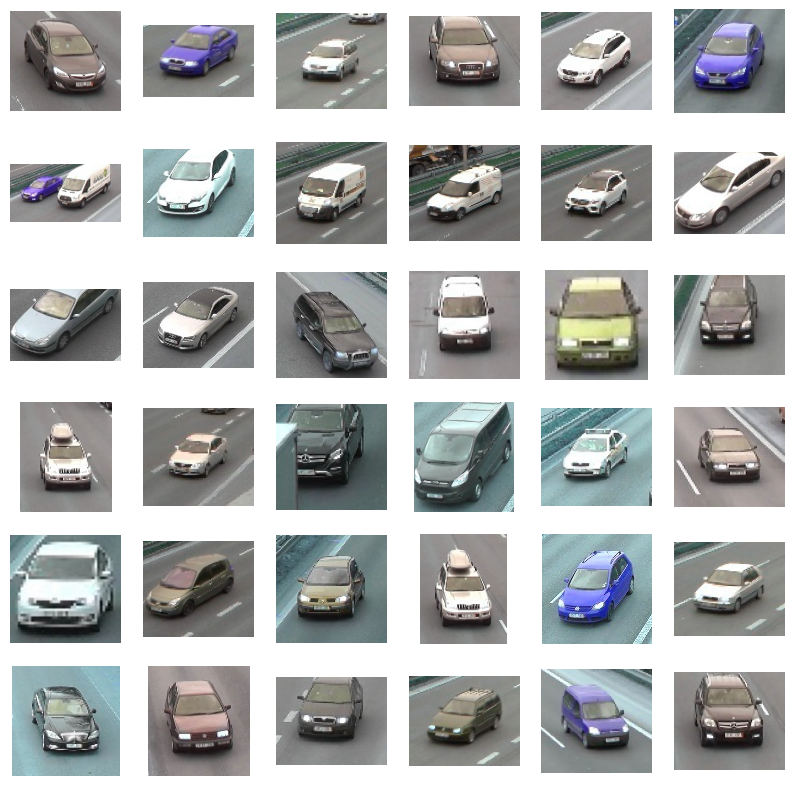

In [6]:
show_sample_images(images, reshape=None)

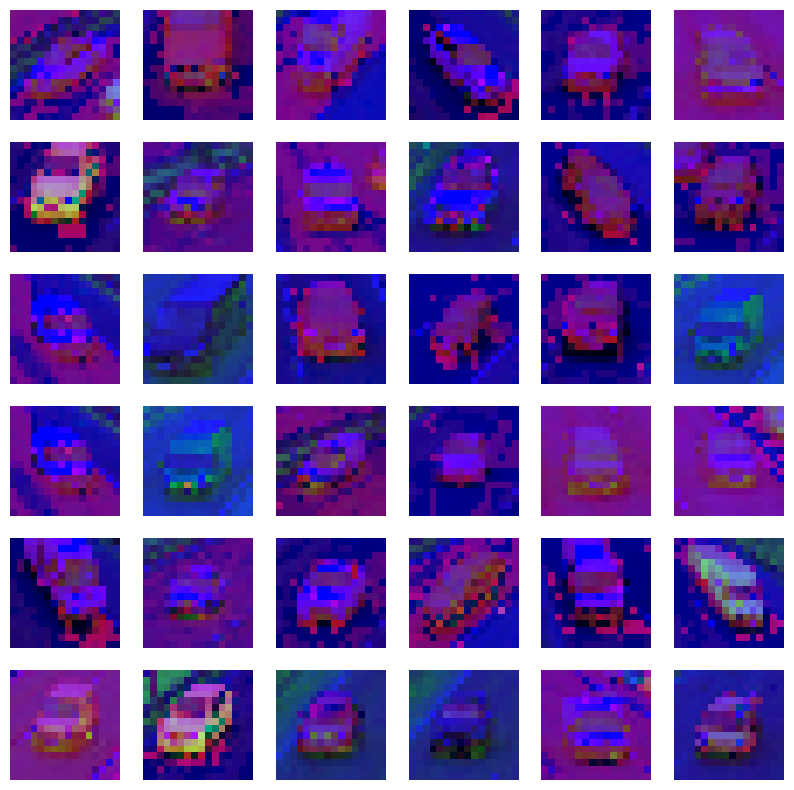

In [7]:
# Praproses gambar
X = preprocess_images(images)

# Enkode label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Bagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

show_sample_images(X_train, cmap='hsv')


In [8]:
# Tentukan pipeline model
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True)),
])

# Tentukan parameter untuk GridSearchCV
grid_params = {
    'classifier__C': [10], 
    'classifier__gamma': ['auto'],
    'classifier__degree': [3],
}

# Lakukan Grid Search dengan Cross Validation
clf = GridSearchCV(model_pipeline, grid_params, verbose=3, cv=10, scoring='accuracy', n_jobs=-1)

# Latih model
clf.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 7/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.640 total time=  23.5s
[CV 8/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.658 total time=  23.7s
[CV 2/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.683 total time=  24.0s
[CV 3/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.671 total time=  23.9s
[CV 5/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.634 total time=  24.0s
[CV 1/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.636 total time=  24.2s
[CV 4/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.727 total time=  24.1s
[CV 6/10] END classifier__C=10, classifier__degree=3, classifier__gamma=auto;, score=0.689 total time=  24.2s
[CV 9/10] END classifier__C=10, classifier__degree=3, class

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'classifier__C': [10], 'classifier__degree': [3],
                         'classifier__gamma': ['auto']},
             scoring='accuracy', verbose=3)

In [9]:
label_encoder.classes_

array(['citycar', 'sedan', 'sport', 'van'], dtype='<U7')

In [10]:
class_names = dict(enumerate(map(str, label_encoder.classes_)))
class_names

{0: 'citycar', 1: 'sedan', 2: 'sport', 3: 'van'}

In [11]:
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

     citycar       0.60      0.56      0.58       116
       sedan       0.63      0.64      0.64       106
       sport       0.69      0.70      0.69        84
         van       0.83      0.86      0.84        97

    accuracy                           0.68       403
   macro avg       0.69      0.69      0.69       403
weighted avg       0.68      0.68      0.68       403



In [12]:
X_test[:1].shape

(1, 768)

In [13]:
onnx = to_onnx(best_model, X_test[:1].astype(np.float32), options={"zipmap": False})

In [14]:
from onnxruntime import InferenceSession
sess = InferenceSession(onnx.SerializeToString())
sess.get_modelmeta()

In [15]:
pred_ort = sess.run(None, {"X": X_test[:5].astype(np.float32)})[0]
pred_skl = best_model.predict(X_test[:5].astype(np.float32))

print("Onnx Runtime prediction:\n", pred_ort)
print("Sklearn rediction:\n", pred_skl)

Onnx Runtime prediction:
 [1 1 0 2 0]
Sklearn rediction:
 [1 1 0 2 0]


In [16]:
import json
m1 = onnx.metadata_props.add()
m1.key = 'class_names'
m1.value = json.dumps(class_names)

In [17]:
m2 = onnx.metadata_props.add()
m2.key = 'model_name'
m2.value = '''
this docstring metadata
can be include preprocessor
'''

In [21]:
import pickle as pkl

with open('../models/model.pkl', 'wb') as f:
    pkl.dump(best_model, f)
    
with open('../models/model.onnx', 'wb') as f:
    f.write(onnx.SerializeToString()) # type: ignore
